In [1]:
!pip install openai-whisper==20250625 --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 45.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=8981c61921634bf98b0228a1b0b50f49dd3f9218985ae2f8115b60ea58e69ed7
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
12.6


In [2]:
import whisper
model = whisper.load_model("small").to("cuda")
print("Whisper small loaded!")

100%|████████████████████████████████████████| 461M/461M [00:02<00:00, 233MiB/s]


Whisper small loaded!


In [ ]:
result1 = model.transcribe("common_voice_zh-HK_20099797.wav", fp16=False)
print(result1["text"])
result2 = model.transcribe("common_voice_zh-HK_20101461.wav", fp16=False)
print(result2["text"])
result3 = model.transcribe("common_voice_zh-HK_20101462.wav", fp16=False)
print(result3["text"])
result4 = model.transcribe("common_voice_zh-HK_20101463.wav", fp16=False)
print(result4["text"])

小朋友在九龍城沙袍收養了一隻流浪狗
8號風球好大風,西形盤跌獄里,現在環風環雨。
有個老婆婆在牛慈灣,指揮路等著小巴。
城門水塘水製房


In [ ]:
!pip install modelscope


In [ ]:
!pip install addict

In [ ]:
!git clone https://www.modelscope.cn/datasets/tomsawyerhu/cantonese-dialect.git

Cloning into 'cantonese-dialect'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 46 (delta 21), reused 30 (delta 11), pack-reused 0
Receiving objects: 100% (46/46), 372.35 KiB | 1.22 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [4]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="train.csv")["train"]

# ⭐ 新增：去除 Text 中所有空格（包括中英文空格）
def clean_text(batch):
    if "Text" in batch and isinstance(batch["Text"], str):
        batch["Text"] = batch["Text"].replace(" ", "")
    return batch

dataset = dataset.map(clean_text)

dataset[0]


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

{'Audio': 'https://dataset-hub.oss-cn-hangzhou.aliyuncs.com/public-unzipped/tomsawyerhu_cantonese-dialect_cantonese_dialect_small/cantonese_dialect_small/common_voice_zh-HK_22262988.wav?Expires=1763882317&OSSAccessKeyId=LTAI5tAoCEDFQFyV5h8unjt8&Signature=TC73%2FQfFxeEO%2FETQyTanGyunwvk%3D',
 'Text': '有个老人去左坪洲永安横街食斋'}

In [6]:
import os
import requests

os.makedirs("audio_cache", exist_ok=True)

def download_audio(batch):
    url = batch["Audio"]
    filename = url.split("/")[-1].split("?")[0]  # 去掉URL参数
    path = f"audio_cache/{filename}"

    if not os.path.exists(path):
        with open(path, "wb") as f:
            f.write(requests.get(url).content)

    batch["audio_path"] = path
    return batch

dataset = dataset.map(download_audio)


Map:   0%|          | 0/198 [00:00<?, ? examples/s]

In [7]:
import librosa

def load_and_resample(batch):
    speech, sr = librosa.load(batch["audio_path"], sr=16000)
    batch["speech"] = speech
    batch["sampling_rate"] = 16000
    return batch

dataset = dataset.map(load_and_resample)


Map:   0%|          | 0/198 [00:00<?, ? examples/s]

In [8]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="yue", task="transcribe")

def prepare_features(batch):
    inputs = processor(
        batch["speech"],
        sampling_rate=16000,
        text=batch["Text"]
    )
    batch["input_features"] = inputs["input_features"][0]
    batch["labels"] = inputs["labels"]
    return batch

dataset = dataset.map(prepare_features, remove_columns=dataset.column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

In [9]:
import torch

class WhisperDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, batch):
        # 1. 处理输入特征 (mel spectrogram)
        input_features = [item["input_features"] for item in batch]
        batch_inputs = self.processor.feature_extractor.pad(
            {"input_features": input_features},
            return_tensors="pt"
        )

        # 2. 处理标签
        labels = [item["labels"] for item in batch]
        batch_labels = self.processor.tokenizer.pad(
            {"input_ids": labels},
            padding=True,
            return_tensors="pt"
        )["input_ids"]

        # Whisper 要把 padding 部分改成 -100
        batch_labels[batch_labels == self.processor.tokenizer.pad_token_id] = -100

        batch_inputs["labels"] = batch_labels
        return batch_inputs


In [10]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import TrainingArguments, Trainer

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="yue", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

data_collator = WhisperDataCollator(processor)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [11]:
training_args = TrainingArguments(
    output_dir="./whisper-small-cantonese",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    fp16=True,
    learning_rate=1e-5,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_steps=20,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=processor.feature_extractor,
    data_collator=data_collator   # ⭐ 使用自定义 Collator
)

trainer.train()

trainer.save_model("./whisper-small-cantonese")
processor.save_pretrained("./whisper-small-cantonese")


/tmp/ipython-input-2013318309.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 490051963 (490051963-south-china-normal-unive

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
20,4.141600
40,1.680400


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss
20,4.141600
40,1.680400
60,1.305400


[]

In [ ]:
!pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 103.8 MB/s eta 0:00:00


In [28]:
import csv
import os

test_dir = "test"
csv_path = os.path.join(test_dir, "test.csv")

audio_files = []
labels = []

with open(csv_path, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        filename = row["Audio:FILE"].strip()
        text = row["Text:LABEL"].strip().replace(" ", "")
        audio_files.append(os.path.join(test_dir, filename))
        labels.append(text)
print(len(audio_files), "samples loaded")
print(audio_files[0], labels[0])


19 samples loaded
test/common_voice_zh-HK_20110217.wav 有个老婆婆喺大埔滘翠峦路等紧小巴


In [13]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import librosa

device = "cuda"

# 原始模型（微调前）
processor_base = WhisperProcessor.from_pretrained("openai/whisper-small")
model_base = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

# 微调后的模型
processor_ft = WhisperProcessor.from_pretrained("./whisper-small-cantonese")
model_ft = WhisperForConditionalGeneration.from_pretrained("./whisper-small-cantonese").to(device)


In [14]:
def transcribe(model, processor, audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt").to(device)
    with torch.no_grad():
        ids = model.generate(inputs.input_features)
    return processor.batch_decode(ids, skip_special_tokens=True)[0]


In [29]:
pred_base = []
pred_ft = []

for wav in audio_files:
    pred_base.append(transcribe(model_base, processor_base, wav))
    pred_ft.append(transcribe(model_ft, processor_ft, wav))


In [17]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 112.6 MB/s eta 0:00:00


In [30]:
from jiwer import wer, cer

print("---- BEFORE FINETUNE ----")
print("WER:", wer(labels, pred_base))
print("CER:", cer(labels, pred_base))

print("\n---- AFTER FINETUNE ----")
print("WER:", wer(labels, pred_ft))
print("CER:", cer(labels, pred_ft))


---- BEFORE FINETUNE ----
WER: 1.105263157894737
CER: 0.606694560669456

---- AFTER FINETUNE ----
WER: 0.9473684210526315
CER: 0.37656903765690375


In [31]:
for i in range(len(audio_files)):
    print(f"[{i}] {audio_files[i]}")
    print("   Label     :", labels[i])
    print("   Before FT :", pred_base[i])
    print("   After  FT :", pred_ft[i])
    print("-"*80)


[0] test/common_voice_zh-HK_20110217.wav
   Label     : 有个老婆婆喺大埔滘翠峦路等紧小巴
   Before FT : 有個老婆婆在大埔教翠聯路等小巴
   After  FT : 有个老婆婆喺大埔教翠联路等紫巴呀。
--------------------------------------------------------------------------------
[1] test/common_voice_zh-HK_20110228.wav
   Label     : 鸭巴甸新道
   Before FT : 鴨巴天身道
   After  FT : 瓦巴点身道
--------------------------------------------------------------------------------
[2] test/common_voice_zh-HK_20110241.wav
   Label     : 比我一个人静下得唔得
   Before FT : 給我一個人靜一下行不行
   After  FT : 比我一个人靜下得唔得?
--------------------------------------------------------------------------------
[3] test/common_voice_zh-HK_20136999.wav
   Label     : 流浪猫喺沙田禾盛街嘅垃圾桶揾野食
   Before FT : 流浪貓在沙田和盛街的垃圾桶找食物
   After  FT : 流浪猫喺沙田和圣街嘅垃圾桶揾野食。
--------------------------------------------------------------------------------
[4] test/common_voice_zh-HK_20137068.wav
   Label     : 好耐无去观塘功乐道探舅父
   Before FT : 很久沒有去觀塘攻落度探口府
   After  FT : 好耐无去观塘公乐道探口府。
-------------------------------------------------

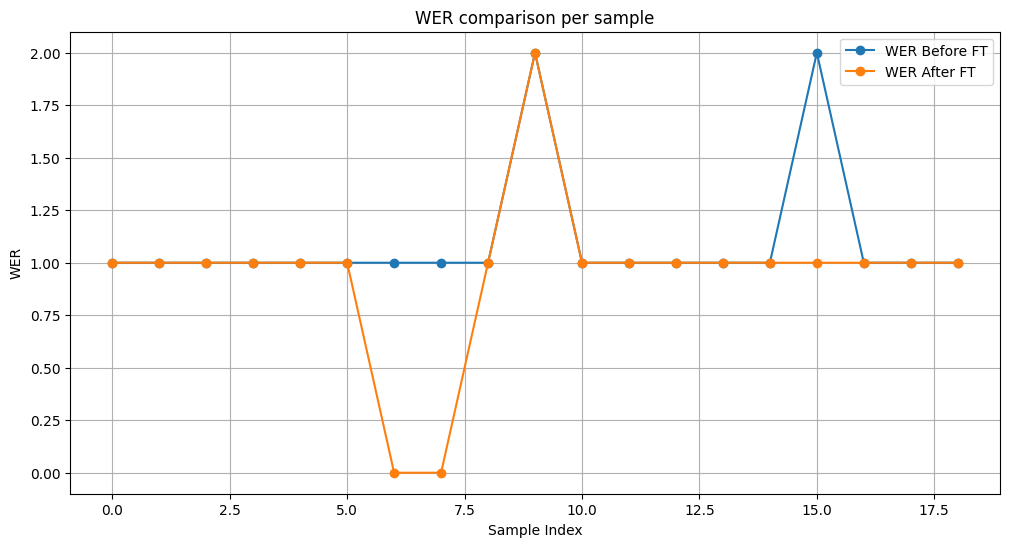

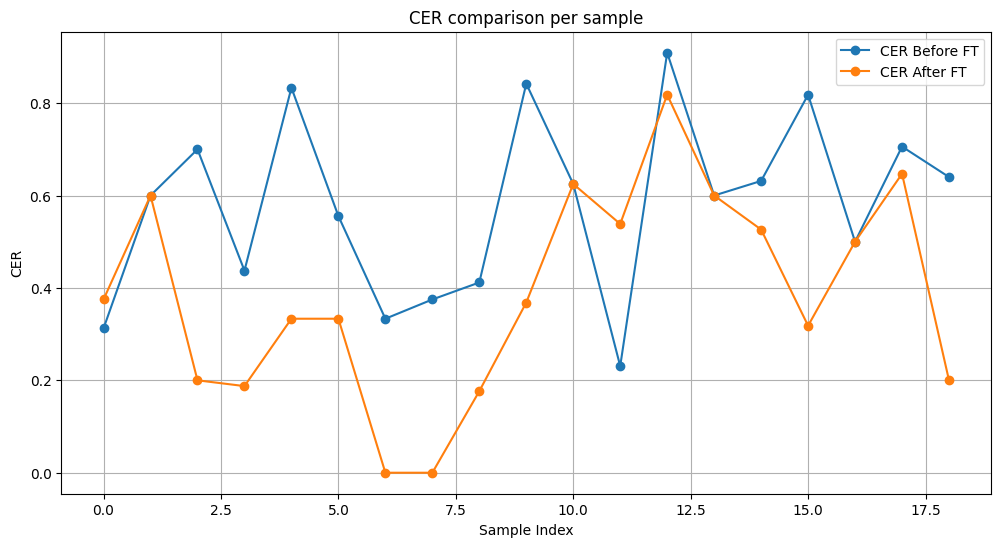

In [32]:
import matplotlib.pyplot as plt
from jiwer import wer, cer

wer_base_list = []
wer_ft_list = []
cer_base_list = []
cer_ft_list = []

for ref, b, f in zip(labels, pred_base, pred_ft):
    wer_base_list.append(wer([ref], [b]))
    wer_ft_list.append(wer([ref], [f]))
    cer_base_list.append(cer([ref], [b]))
    cer_ft_list.append(cer([ref], [f]))

plt.figure(figsize=(12,6))
plt.plot(wer_base_list, label="WER Before FT", marker="o")
plt.plot(wer_ft_list, label="WER After FT", marker="o")
plt.title("WER comparison per sample")
plt.xlabel("Sample Index")
plt.ylabel("WER")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cer_base_list, label="CER Before FT", marker="o")
plt.plot(cer_ft_list, label="CER After FT", marker="o")
plt.title("CER comparison per sample")
plt.xlabel("Sample Index")
plt.ylabel("CER")
plt.legend()
plt.grid()
plt.show()


mt机器翻译模型实现

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# # 小型、支持粤语的翻译模型
# model_name = "facebook/nllb-200-distilled-600M"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

In [ ]:
# # Whisper 识别到的文本（粤语/繁体）
# text = result1["text"]
# print(text)
# # ★ 你的 tokenizer 中的有效语言代码：
# src_lang = "yue_Hant"     # 粤语（繁体）
# tgt_lang = "zho_Hans"     # 中文（简体）

# # ★ 在输入文本前加入语言 token（不加尖括号！）
# src_prefixed = src_lang + " " + text

# inputs = tokenizer(
#     src_prefixed,
#     return_tensors="pt",
#     padding=True,
#     truncation=True
# ).to("cuda")

# # ★ 获取目标语言 ID（直接用语言码，不加尖括号）
# tgt_lang_id = tokenizer.convert_tokens_to_ids(tgt_lang)

# generated_tokens = model.generate(
#     **inputs,
#     forced_bos_token_id=tgt_lang_id,
#     max_length=256
# )

# translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# print(translation[0])

小朋友在九龍城沙袍收養了一隻流浪狗
孩子在九龙城收养了一只流浪狗.


In [ ]:
# pip install --no-deps edge-tts -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


tts模块，不确定是否能正确输出

In [ ]:
# import edge_tts
# import nest_asyncio
# import asyncio

# nest_asyncio.apply()

# text = translation[0]

# def tts_save(text):
#     tts = edge_tts.Communicate(text, voice="zh-CN-XiaoxiaoNeural")
#     tts.save("output.mp3")
#     print("保存成功：output.mp3")

# tts_save(text)


保存成功：output.mp3


/tmp/ipython-input-3475067818.py:11: RuntimeWarning: coroutine 'Communicate.save' was never awaited
  tts.save("output.mp3")


In [ ]:
!pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.11.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.1
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                                0.9.19
argon2-cffi                        

In [33]:
from huggingface_hub import HfApi

api = HfApi(token="***")
api.upload_folder(
    folder_path="./whisper-small-cantonese",
    repo_id="baikai1022/whisper-small-cantonese",
    repo_type="model",
    ignore_patterns=["checkpoint-*"],
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ntonese/model.safetensors:   0%|          |  570kB /  967MB            

  ...66720.ac31a3d4d09f.1027.0:  14%|#3        | 1.05kB / 7.59kB            

  ...ntonese/training_args.bin:  14%|#3        |   809B / 5.84kB            

CommitInfo(commit_url='https://huggingface.co/baikai1022/whisper-small-cantonese/commit/861c50e9d92fe5cc3500022c3b8711af89180904', commit_message='Upload folder using huggingface_hub', commit_description='', oid='861c50e9d92fe5cc3500022c3b8711af89180904', pr_url=None, repo_url=RepoUrl('https://huggingface.co/baikai1022/whisper-small-cantonese', endpoint='https://huggingface.co', repo_type='model', repo_id='baikai1022/whisper-small-cantonese'), pr_revision=None, pr_num=None)